## 1. 环境设置与数据加载

In [2]:
# 必须先安装库: pip install imbalanced-learn
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 设置matplotlib中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成")
print("已导入神经网络模块 (MLPClassifier)")

环境配置完成
已导入神经网络模块 (MLPClassifier)


In [3]:
# 读取数据
train_df = pd.read_csv('../data/train.csv')
test_in_domain = pd.read_csv('../data/test_in_domain.csv')
test_cross_domain = pd.read_csv('../data/test_cross_domain.csv')

# 分离训练集的特征和标签
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

# 测试集只有特征,没有标签
X_test_in = test_in_domain  # 不需要drop label,因为测试集没有label列
X_test_cross = test_cross_domain  # 不需要drop label,因为测试集没有label列

print(f"训练集形状: {X_train.shape}")
print(f"训练集标签形状: {y_train.shape}")
print(f"域内测试集形状: {X_test_in.shape}")
print(f"跨域测试集形状: {X_test_cross.shape}")
print(f"标签分布:\n{y_train.value_counts()}")
print("数据加载完成!")


训练集形状: (196, 12700)
训练集标签形状: (196,)
域内测试集形状: (84, 12700)
跨域测试集形状: (200, 12700)
标签分布:
label
1    126
0     70
Name: count, dtype: int64
数据加载完成!


## 2. 数据预处理与特征工程

In [4]:
# 步骤1: 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_in_scaled = scaler.transform(X_test_in)
X_test_cross_scaled = scaler.transform(X_test_cross)

print("数据标准化完成")
print(f"训练集均值: {X_train_scaled.mean():.6f}, 标准差: {X_train_scaled.std():.6f}")

数据标准化完成
训练集均值: -0.000000, 标准差: 1.000000


In [5]:
# 步骤2: 方差过滤 (移除低方差特征)
variance_threshold = 0.01
selector_variance = VarianceThreshold(threshold=variance_threshold)
X_train_var = selector_variance.fit_transform(X_train_scaled)
X_test_in_var = selector_variance.transform(X_test_in_scaled)
X_test_cross_var = selector_variance.transform(X_test_cross_scaled)

n_features_removed = X_train_scaled.shape[1] - X_train_var.shape[1]
print(f"\n方差过滤 (阈值={variance_threshold})")
print(f"移除特征数: {n_features_removed}")
print(f"剩余特征数: {X_train_var.shape[1]}")


方差过滤 (阈值=0.01)
移除特征数: 0
剩余特征数: 12700


In [6]:
# 步骤3: 单变量特征选择 (ANOVA F-score)
# 选择前500个最佳特征 (可调整)
k_best = min(500, X_train_var.shape[1])
selector_kbest = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector_kbest.fit_transform(X_train_var, y_train)
X_test_in_selected = selector_kbest.transform(X_test_in_var)
X_test_cross_selected = selector_kbest.transform(X_test_cross_var)

print(f"\n特征选择 (SelectKBest, k={k_best})")
print(f"选择特征数: {X_train_selected.shape[1]}")
print(f"新的样本/特征比: {X_train_selected.shape[0] / X_train_selected.shape[1]:.4f}")


特征选择 (SelectKBest, k=500)
选择特征数: 500
新的样本/特征比: 0.3920


In [7]:
# 可选: PCA降维 (保留95%方差)
use_pca = False  # 设置为True启用PCA

if use_pca:
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_final = pca.fit_transform(X_train_selected)
    X_test_in_final = pca.transform(X_test_in_selected)
    X_test_cross_final = pca.transform(X_test_cross_selected)
    print(f"\nPCA降维 (保留95%方差)")
    print(f"主成分数: {X_train_final.shape[1]}")
    print(f"解释方差比: {pca.explained_variance_ratio_.sum():.4f}")
else:
    X_train_final = X_train_selected
    X_test_in_final = X_test_in_selected
    X_test_cross_final = X_test_cross_selected
    print("\n跳过PCA降维，直接使用选择后的特征")

print(f"\n最终特征维度: {X_train_final.shape[1]}")


跳过PCA降维，直接使用选择后的特征

最终特征维度: 500


## 3. 模型训练与交叉验证

In [8]:
# 定义评估指标
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# 设置交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("交叉验证设置: 5折分层K折")

交叉验证设置: 5折分层K折


In [9]:
# 初始化结果字典
results = {}
print("准备分别训练8个模型(包括神经网络),每个模型单独调优...")


准备分别训练8个模型(包括神经网络),每个模型单独调优...


In [10]:
### 3.1 Logistic Regression - 逻辑回归

In [11]:
print("="*60)
print("训练模型 1/8: Logistic Regression (ADASYN)")
print("="*60)

# 1. 定义基础模型 (移除 class_weight='balanced')
lr_clf = LogisticRegression(
    max_iter=1000,
    C=1, 
    penalty='l2',
    solver='lbfgs',
    random_state=RANDOM_STATE
)

# 2. 构建 ADASYN 流水线
lr_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', lr_clf)
])

# 3. 交叉验证
cv_results = cross_validate(
    lr_pipeline,  # 传入流水线
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

# 4. 保存结果
results['Logistic Regression'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['Logistic Regression']['test_roc_auc']:.4f} (±{results['Logistic Regression']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['Logistic Regression']['test_accuracy']:.4f}")
print("✓ 完成")

训练模型 1/8: Logistic Regression (ADASYN)
ROC-AUC: 0.9404 (±0.0197)
Accuracy: 0.8574
✓ 完成


### 3.2 SVM (Linear Kernel) - 线性支持向量机

In [12]:
print("\n" + "="*60)
print("训练模型 2/8: SVM (Linear) + ADASYN")
print("="*60)

svm_linear_clf = SVC(
    kernel='linear',
    C=1.0,
    probability=True,
    random_state=RANDOM_STATE,
    max_iter=2000
)

svm_linear_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', svm_linear_clf)
])

cv_results = cross_validate(
    svm_linear_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

results['SVM (Linear)'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['SVM (Linear)']['test_roc_auc']:.4f} (±{results['SVM (Linear)']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['SVM (Linear)']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 2/8: SVM (Linear) + ADASYN
ROC-AUC: 0.9360 (±0.0225)
Accuracy: 0.8676
✓ 完成


### 3.3 SVM (RBF Kernel) - RBF核支持向量机

In [13]:
print("\n" + "="*60)
print("训练模型 3/8: SVM (RBF) + ADASYN")
print("="*60)

svm_rbf_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=RANDOM_STATE,
    max_iter=2000
)

svm_rbf_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', svm_rbf_clf)
])

cv_results = cross_validate(
    svm_rbf_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

results['SVM (RBF)'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['SVM (RBF)']['test_roc_auc']:.4f} (±{results['SVM (RBF)']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['SVM (RBF)']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 3/8: SVM (RBF) + ADASYN
ROC-AUC: 0.9089 (±0.0276)
Accuracy: 0.8115
✓ 完成


### 3.4 Random Forest - 随机森林

In [14]:
print("\n" + "="*60)
print("训练模型 4/8: Random Forest (ADASYN)")
print("="*60)

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', rf_clf)
])

cv_results = cross_validate(
    rf_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

results['Random Forest'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['Random Forest']['test_roc_auc']:.4f} (±{results['Random Forest']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['Random Forest']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 4/8: Random Forest (ADASYN)
ROC-AUC: 0.8568 (±0.0602)
Accuracy: 0.7913
✓ 完成


### 3.5 Gradient Boosting - 梯度提升

In [15]:
print("\n" + "="*60)
print("训练模型 5/8: Gradient Boosting (ADASYN)")
print("="*60)

gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=RANDOM_STATE
)

gb_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', gb_clf)
])

cv_results = cross_validate(
    gb_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

results['Gradient Boosting'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['Gradient Boosting']['test_roc_auc']:.4f} (±{results['Gradient Boosting']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['Gradient Boosting']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 5/8: Gradient Boosting (ADASYN)
ROC-AUC: 0.8595 (±0.0461)
Accuracy: 0.7808
✓ 完成


### 3.6 K-Nearest Neighbors - K近邻

In [16]:
print("\n" + "="*60)
print("训练模型 6/8: K-Nearest Neighbors (ADASYN)")
print("="*60)

knn_clf = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='minkowski',
    p=2,
    n_jobs=-1
)

knn_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', knn_clf)
])

cv_results = cross_validate(
    knn_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

results['K-Nearest Neighbors'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['K-Nearest Neighbors']['test_roc_auc']:.4f} (±{results['K-Nearest Neighbors']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['K-Nearest Neighbors']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 6/8: K-Nearest Neighbors (ADASYN)
ROC-AUC: 0.7706 (±0.0716)
Accuracy: 0.6273
✓ 完成


### 3.7 Naive Bayes - 朴素贝叶斯

In [17]:
print("\n" + "="*60)
print("训练模型 7/8: Naive Bayes (ADASYN)")
print("="*60)

nb_clf = GaussianNB(var_smoothing=1e-9)

nb_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', nb_clf)
])

cv_results = cross_validate(
    nb_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

results['Naive Bayes'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['Naive Bayes']['test_roc_auc']:.4f} (±{results['Naive Bayes']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['Naive Bayes']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 7/8: Naive Bayes (ADASYN)
ROC-AUC: 0.8362 (±0.0383)
Accuracy: 0.7705
✓ 完成


### 3.8 Neural Network (MLP) - 多层感知机神经网络

In [18]:
print("\n" + "="*60)
print("训练模型 8/8: Neural Network (MLP + ADASYN)")
print("="*60)

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=RANDOM_STATE,
    verbose=False
)

mlp_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('classifier', mlp_clf)
])

cv_results = cross_validate(
    mlp_pipeline, 
    X_train_final, 
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=1  # 神经网络建议使用单线程防止报错
)

results['Neural Network (MLP)'] = {
    'train_roc_auc': cv_results['train_roc_auc'].mean(),
    'test_roc_auc': cv_results['test_roc_auc'].mean(),
    'test_roc_auc_std': cv_results['test_roc_auc'].std(),
    'test_accuracy': cv_results['test_accuracy'].mean(),
    'test_accuracy_std': cv_results['test_accuracy'].std(),
    'test_f1': cv_results['test_f1'].mean(),
    'test_f1_std': cv_results['test_f1'].std(),
    'test_precision': cv_results['test_precision'].mean(),
    'test_recall': cv_results['test_recall'].mean(),
    'fit_time': cv_results['fit_time'].mean()
}

print(f"ROC-AUC: {results['Neural Network (MLP)']['test_roc_auc']:.4f} (±{results['Neural Network (MLP)']['test_roc_auc_std']:.4f})")
print(f"Accuracy: {results['Neural Network (MLP)']['test_accuracy']:.4f}")
print("✓ 完成")


训练模型 8/8: Neural Network (MLP + ADASYN)
ROC-AUC: 0.8927 (±0.0680)
Accuracy: 0.7964
✓ 完成


## 4. 模型性能对比

In [19]:
# 创建结果对比表
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('test_roc_auc', ascending=False)

print("\n" + "="*80)
print("模型性能对比 (按ROC-AUC排序)")
print("="*80)

display_df = results_df[[
    'test_roc_auc', 'test_roc_auc_std',
    'test_accuracy', 'test_accuracy_std',
    'test_f1', 'test_f1_std',
    'test_precision', 'test_recall',
    'fit_time'
]].copy()

display_df.columns = [
    'ROC-AUC', 'ROC-AUC Std',
    'Accuracy', 'Acc Std',
    'F1-Score', 'F1 Std',
    'Precision', 'Recall',
    'Time(s)'
]

print(display_df.round(4))

# 找出最优模型
best_model_name = results_df.index[0]
print(f"\n最优模型 (基于ROC-AUC): {best_model_name}")
print(f"ROC-AUC: {results_df.iloc[0]['test_roc_auc']:.4f}")


模型性能对比 (按ROC-AUC排序)
                      ROC-AUC  ROC-AUC Std  Accuracy  Acc Std  F1-Score  \
Logistic Regression    0.9404       0.0197    0.8574   0.0565    0.8866   
SVM (Linear)           0.9360       0.0225    0.8676   0.0461    0.8960   
SVM (RBF)              0.9089       0.0276    0.8115   0.0512    0.8572   
Neural Network (MLP)   0.8927       0.0680    0.7964   0.0645    0.8359   
Gradient Boosting      0.8595       0.0461    0.7808   0.0335    0.8378   
Random Forest          0.8568       0.0602    0.7913   0.0467    0.8452   
Naive Bayes            0.8362       0.0383    0.7705   0.0644    0.8119   
K-Nearest Neighbors    0.7706       0.0716    0.6273   0.0403    0.6048   

                      F1 Std  Precision  Recall  Time(s)  
Logistic Regression   0.0500     0.9017  0.8883   0.0552  
SVM (Linear)          0.0400     0.9030  0.9040   0.0798  
SVM (RBF)             0.0419     0.8370  0.8886   0.0682  
Neural Network (MLP)  0.0505     0.8808  0.8089   0.8796  
Gradient

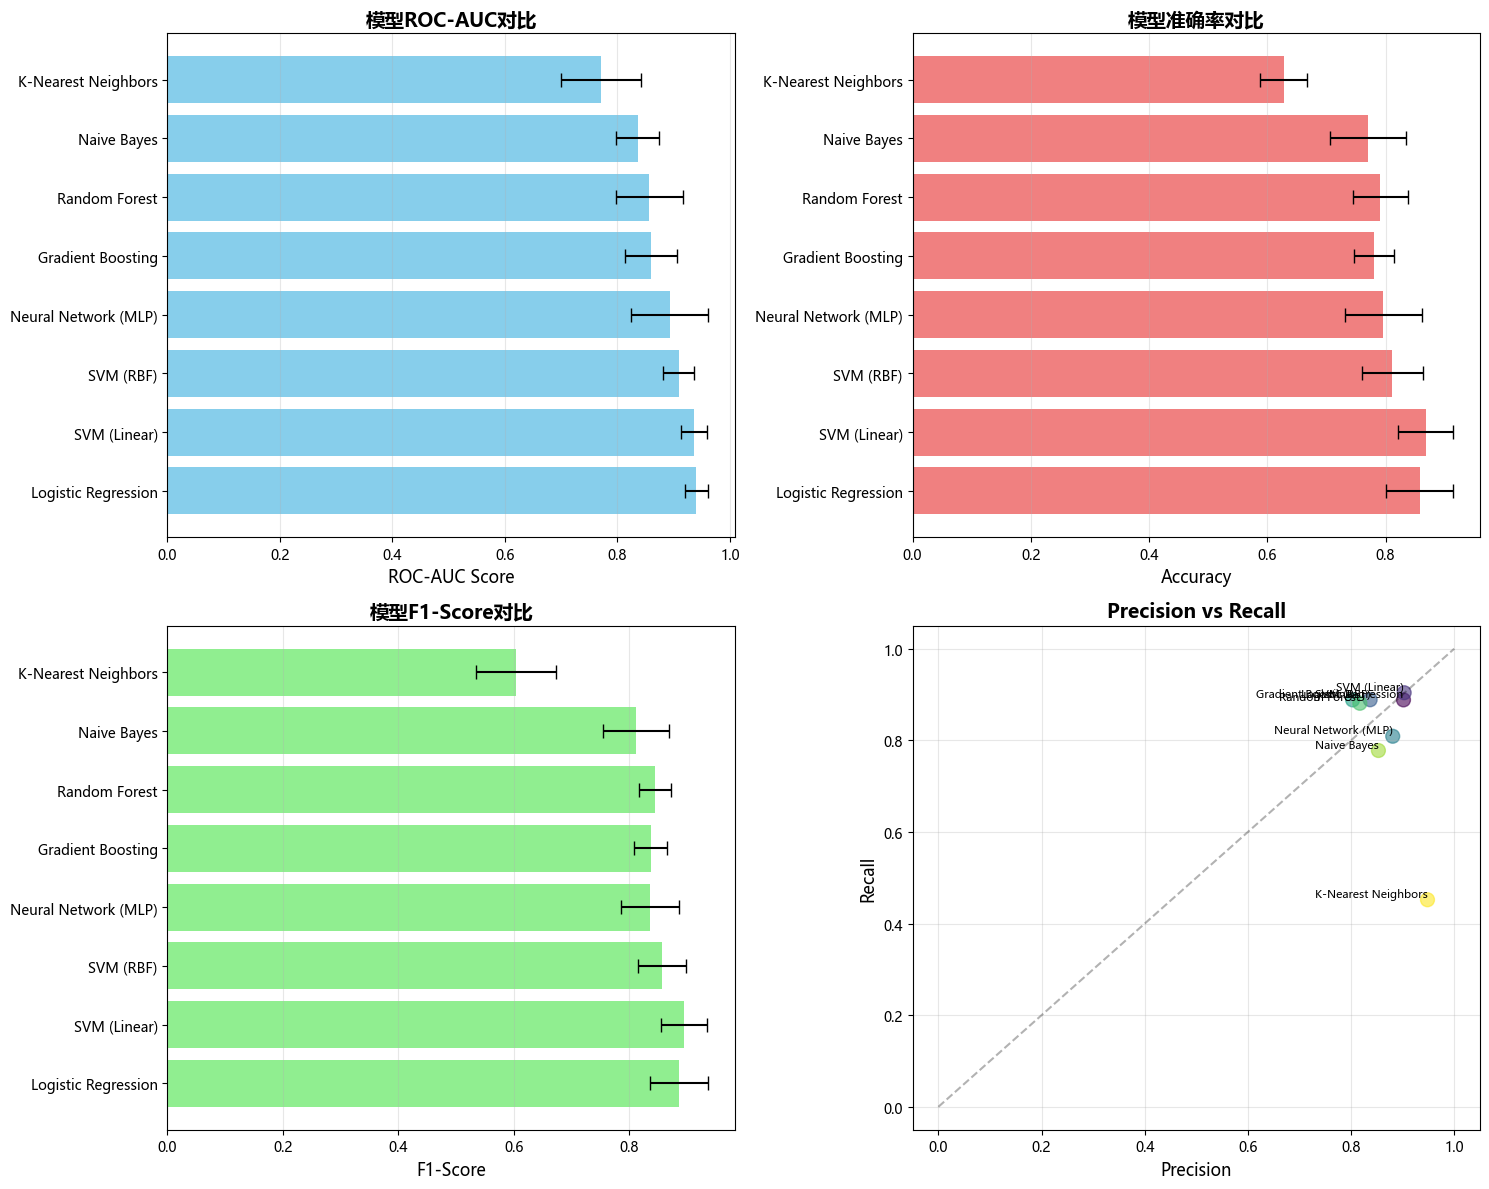

性能对比图已保存到 ../docs/images/08_augmentation_model_comparison.png


In [20]:
# 可视化对比
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC-AUC对比
ax1 = axes[0, 0]
model_names = results_df.index
roc_aucs = results_df['test_roc_auc']
roc_stds = results_df['test_roc_auc_std']
ax1.barh(model_names, roc_aucs, xerr=roc_stds, capsize=5, color='skyblue')
ax1.set_xlabel('ROC-AUC Score', fontsize=12)
ax1.set_title('模型ROC-AUC对比', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Accuracy对比
ax2 = axes[0, 1]
accuracies = results_df['test_accuracy']
acc_stds = results_df['test_accuracy_std']
ax2.barh(model_names, accuracies, xerr=acc_stds, capsize=5, color='lightcoral')
ax2.set_xlabel('Accuracy', fontsize=12)
ax2.set_title('模型准确率对比', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# F1-Score对比
ax3 = axes[1, 0]
f1_scores = results_df['test_f1']
f1_stds = results_df['test_f1_std']
ax3.barh(model_names, f1_scores, xerr=f1_stds, capsize=5, color='lightgreen')
ax3.set_xlabel('F1-Score', fontsize=12)
ax3.set_title('模型F1-Score对比', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Precision vs Recall
ax4 = axes[1, 1]
precisions = results_df['test_precision']
recalls = results_df['test_recall']
ax4.scatter(precisions, recalls, s=100, alpha=0.6, c=range(len(model_names)), cmap='viridis')
for i, name in enumerate(model_names):
    ax4.annotate(name, (precisions[i], recalls[i]), 
                fontsize=8, ha='right', va='bottom')
ax4.set_xlabel('Precision', fontsize=12)
ax4.set_ylabel('Recall', fontsize=12)
ax4.set_title('Precision vs Recall', fontsize=14, fontweight='bold')
ax4.grid(alpha=0.3)
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/images/08_augmentation_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("性能对比图已保存到 ../docs/images/08_augmentation_model_comparison.png")

## 5. 最优模型训练与测试集预测

In [21]:
# 使用全部训练数据训练最优模型
# 先创建所有模型的字典
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, C=0.1, penalty='l2', solver='lbfgs', random_state=RANDOM_STATE, class_weight='balanced'),
    'SVM (Linear)': SVC(kernel='linear', C=1.0, probability=True, random_state=RANDOM_STATE, class_weight='balanced', max_iter=3000),
    'SVM (RBF)': SVC(kernel='rbf', C=10.0, gamma='scale', probability=True, random_state=RANDOM_STATE, class_weight='balanced', max_iter=3000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, min_samples_split=5, min_samples_leaf=2, subsample=0.8, random_state=RANDOM_STATE),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski', p=2, n_jobs=-1),
    'Naive Bayes': GaussianNB(var_smoothing=1e-9),
    'Neural Network (MLP)': MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', alpha=0.001, batch_size=32, learning_rate='adaptive', learning_rate_init=0.001, max_iter=500, early_stopping=True, validation_fraction=0.1, n_iter_no_change=20, random_state=RANDOM_STATE, verbose=False)
}

best_model = models[best_model_name]
print(f"使用全部训练数据训练最优模型: {best_model_name}")
best_model.fit(X_train_final, y_train)
print("训练完成")

# 如果最优模型是神经网络,显示训练信息
if best_model_name == 'Neural Network (MLP)':
    print(f"\n神经网络训练详情:")
    print(f"  实际迭代次数: {best_model.n_iter_}")
    print(f"  最终损失: {best_model.loss_:.6f}")
    if hasattr(best_model, 'best_loss_'):
        print(f"  最佳验证损失: {best_model.best_loss_:.6f}")

使用全部训练数据训练最优模型: Logistic Regression
训练完成


In [22]:
# 域内测试集预测(测试集没有标签,仅生成预测结果)
y_pred_in = best_model.predict(X_test_in_final)
y_pred_proba_in = best_model.predict_proba(X_test_in_final)[:, 1]

print("\n" + "="*60)
print("域内测试集预测完成")
print("="*60)
print(f"测试样本数: {len(y_pred_in)}")
print(f"预测为类别0的样本数: {(y_pred_in == 0).sum()}")
print(f"预测为类别1的样本数: {(y_pred_in == 1).sum()}")
print(f"预测概率范围: [{y_pred_proba_in.min():.4f}, {y_pred_proba_in.max():.4f}]")

# 保存预测结果
predictions_in = pd.DataFrame({
    'predicted_label': y_pred_in,
    'probability_class_1': y_pred_proba_in
})
predictions_in.to_csv('../data/augmentation_predictions_in_domain.csv', index=False)
print("\n预测结果已保存到: ../data/augmentation_predictions_in_domain.csv")


域内测试集预测完成
测试样本数: 84
预测为类别0的样本数: 31
预测为类别1的样本数: 53
预测概率范围: [0.0000, 0.9999]

预测结果已保存到: ../data/augmentation_predictions_in_domain.csv


In [23]:
# 跨域测试集预测(测试集没有标签,仅生成预测结果)
y_pred_cross = best_model.predict(X_test_cross_final)
y_pred_proba_cross = best_model.predict_proba(X_test_cross_final)[:, 1]

print("\n" + "="*60)
print("跨域测试集预测完成")
print("="*60)
print(f"测试样本数: {len(y_pred_cross)}")
print(f"预测为类别0的样本数: {(y_pred_cross == 0).sum()}")
print(f"预测为类别1的样本数: {(y_pred_cross == 1).sum()}")
print(f"预测概率范围: [{y_pred_proba_cross.min():.4f}, {y_pred_proba_cross.max():.4f}]")

# 保存预测结果
predictions_cross = pd.DataFrame({
    'predicted_label': y_pred_cross,
    'probability_class_1': y_pred_proba_cross
})
predictions_cross.to_csv('../data/augmentation_predictions_cross_domain.csv', index=False)
print("\n预测结果已保存到: ../data/augmentation_predictions_cross_domain.csv")


跨域测试集预测完成
测试样本数: 200
预测为类别0的样本数: 178
预测为类别1的样本数: 22
预测概率范围: [0.0000, 0.9994]

预测结果已保存到: ../data/augmentation_predictions_cross_domain.csv


## 6. 结果汇总

In [24]:
# 创建完整结果汇总表
summary = pd.DataFrame({
    '模型': list(results.keys()),
    'ROC-AUC (CV)': [f"{results[m]['test_roc_auc']:.4f}" for m in results.keys()],
    'ROC-AUC Std': [f"±{results[m]['test_roc_auc_std']:.4f}" for m in results.keys()],
    'Accuracy (CV)': [f"{results[m]['test_accuracy']:.4f}" for m in results.keys()],
    'F1-Score (CV)': [f"{results[m]['test_f1']:.4f}" for m in results.keys()],
    'Precision': [f"{results[m]['test_precision']:.4f}" for m in results.keys()],
    'Recall': [f"{results[m]['test_recall']:.4f}" for m in results.keys()],
    'Training Time': [f"{results[m]['fit_time']:.4f}s" for m in results.keys()]
})

# 按ROC-AUC排序
summary = summary.sort_values('ROC-AUC (CV)', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print(f"最终结果汇总 - 最优模型: {best_model_name}")
print("="*80)
print(summary.to_string(index=False))

# 保存汇总表
summary.to_csv('../data/augmentation_final_results_summary.csv', index=False)
print("\n结果汇总已保存到: ../data/augmentation_final_results_summary.csv")


最终结果汇总 - 最优模型: Logistic Regression
                  模型 ROC-AUC (CV) ROC-AUC Std Accuracy (CV) F1-Score (CV) Precision Recall Training Time
 Logistic Regression       0.9404     ±0.0197        0.8574        0.8866    0.9017 0.8883       0.0552s
        SVM (Linear)       0.9360     ±0.0225        0.8676        0.8960    0.9030 0.9040       0.0798s
           SVM (RBF)       0.9089     ±0.0276        0.8115        0.8572    0.8370 0.8886       0.0682s
Neural Network (MLP)       0.8927     ±0.0680        0.7964        0.8359    0.8808 0.8089       0.8796s
   Gradient Boosting       0.8595     ±0.0461        0.7808        0.8378    0.8031 0.8883       8.8123s
       Random Forest       0.8568     ±0.0602        0.7913        0.8452    0.8171 0.8809       0.2832s
         Naive Bayes       0.8362     ±0.0383        0.7705        0.8119    0.8531 0.7778       0.0056s
 K-Nearest Neighbors       0.7706     ±0.0716        0.6273        0.6048    0.9482 0.4520       0.0101s

结果汇总已保存到: ../data/

In [25]:
print("\n" + "="*80)
print("实验完成！")
print("="*80)
print(f"\n数据规模: {X_train.shape[0]} 训练样本, {X_train.shape[1]} 原始特征")
print(f"特征工程: {X_train_final.shape[1]} 最终特征")
print(f"\n共训练 {len(results)} 个模型 (包括神经网络)")
print(f"最优模型: {best_model_name}")
print(f"最优ROC-AUC (5折交叉验证): {results[best_model_name]['test_roc_auc']:.4f} (±{results[best_model_name]['test_roc_auc_std']:.4f})")
print(f"\n域内测试集预测:")
print(f"  - 样本数: {len(y_pred_in)}")
print(f"  - 预测结果已保存")
print(f"\n跨域测试集预测:")
print(f"  - 样本数: {len(y_pred_cross)}")
print(f"  - 预测结果已保存")
print("\n所有结果已保存到 data/ 和 docs/images/ 目录")


实验完成！

数据规模: 196 训练样本, 12700 原始特征
特征工程: 500 最终特征

共训练 8 个模型 (包括神经网络)
最优模型: Logistic Regression
最优ROC-AUC (5折交叉验证): 0.9404 (±0.0197)

域内测试集预测:
  - 样本数: 84
  - 预测结果已保存

跨域测试集预测:
  - 样本数: 200
  - 预测结果已保存

所有结果已保存到 data/ 和 docs/images/ 目录
